<a href="https://colab.research.google.com/github/kazemihabib/nlp_assignment_1/blob/LSTM/assignment1_2425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

### Team Members

- **Habib Kazemi**  
  Email: [habib.kazemi2@studio.unibo.it](mailto:habib.kazemi2@studio.unibo.it)  

- **Hesam Sheikh Hassani**  
  Email: [hesam.sheikhhassani@studio.unibo.it](mailto:hesam.sheikhhassani@studio.unibo.it)  

- **Ehsan Ramezani**  
  Email: [ehsan.ramezani@studio.unibo.it](mailto:ehsan.ramezani@studio.unibo.it)  

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Readme:
We store the dataset, cleaned dataset, GloVe embeddings, and other necessary files on Google Drive at the `PATH_IN_G_DRIVE` location. The following cell will automatically download the GloVe embeddings into that `PATH_IN_G_DRIVE` (if not exists already) and then downloads the contents of `PATH_IN_G_DRIVE` to your local environment, once downloaded, we use all local paths for accessing these resources. To streamline the development process, we have also provided the pre-cleaned dataset in the same location, as the dataset cleaning process can be time-consuming. You can explore the contents of the directory using this link: [Google Drive Folder](https://drive.google.com/drive/folders/1c9FPihU6MAadUQkBf7RuzDZsbo3vdH7A?usp=sharing).

In [2]:
import zipfile
import os

PATH_IN_G_DRIVE="/content/drive/MyDrive/Projects/NLP/1"

# If glove embeddings have not been downloaded already, download them to GDrive.
download_path = os.path.join(PATH_IN_G_DRIVE, "glove.6B.zip")

# Check if the file already exists
if not os.path.exists(download_path):
  # Download the GloVe embeddings
  !wget https://nlp.stanford.edu/data/wordvecs/glove.6B.zip -O "$download_path"
else:
  print("File already exists at:", download_path)


# Copy the files in GDrive to my colab local
!cp -r "$PATH_IN_G_DRIVE"/* /content/


########## Unzip embeddings ###############

zip_file_path = "/content/glove.6B.zip"

extract_path = "/content/glove.6B"


if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully extracted files from '{zip_file_path}' to '{extract_path}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
else:
    print(f"Error: '{zip_file_path}' not found.")

File already exists at: /content/drive/MyDrive/Projects/NLP/1/glove.6B.zip
Successfully extracted files from '/content/glove.6B.zip' to '/content/glove.6B'


#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [3]:
!pip install autocorrect
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=1a399f415298a748c617a596f7e8f6a831dd0fd73b8270993a53e1bb4db0323e
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import json
from collections import Counter
import string
import re
import numpy as np
import spacy
# from spellchecker import SpellChecker
from autocorrect import Speller
from pathlib import Path
import os
import optuna
from torch.utils.tensorboard import SummaryWriter

# Also install the following packages
# pip install pyarrow
# pip install torch
# pip install scikit-learn



In [5]:
from IPython.core.magic import register_cell_magic

# Custom magic command to skip the cell
@register_cell_magic
def skip(line, cell):
    return


In [6]:
def mojority_of_votes(votes:list):
    """ given an array of votes, return the mode or None if there is no mode """
    count = Counter(votes)
    most_common = count.most_common(2)
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None
    if most_common:
        return most_common[0][0]

In [7]:
def preprocess(data:pd.DataFrame):
    # method for all the preprocessing steps
    data = data.T # make the attributes as columns and data points as rows
    data['hard_label_task1'] = data['labels_task1'].apply(mojority_of_votes) #generate hard labels
    data = data[data['hard_label_task1'].notna()] # drop rows without a majority label
    data = data[data['lang'] == 'en'] # drop rows where lang is not 'en'
    data = data[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']] # keeping only necessary columns
    data['hard_label_task1'] = data['hard_label_task1'].map({'YES': 1, 'NO': 0}) # encoding 'hard_label_task1' column
    return data

In [8]:
data_training = pd.read_json(Path('data', 'training.json'))
data_test = pd.read_json(Path('data', 'test.json'))
data_validation = pd.read_json(Path('data', 'validation.json'))

data_training = preprocess(data_training)
data_test = preprocess(data_test)
data_validation = preprocess(data_validation)

data_training.head()


,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [9]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
# spaCy English model
nlp = spacy.load('en_core_web_sm')
spell = Speller()

In [11]:

def remove_emojis(text):
    # removing emojis with regex, including
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F914"  # 🤔
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_special_characters(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_quotes(text):
    return text.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')

def lemmatize_text(text):
    # performing lemmatization using spacy
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# =================== Additional preprocessing techniques =================================
# important to reduce the number of unseen vobabs as Glove contains mostly lowercase tokens
def lowercase_text(text):
    return text.lower()  # convert all text to lowercase

def correct_typos(text):
    return spell(text)

def clean_text(tweet):
    tweet = remove_emojis(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_urls(tweet)
    tweet = remove_special_characters(tweet)
    tweet = remove_quotes(tweet)
    tweet = lowercase_text(tweet)
    tweet = correct_typos(tweet)
    tweet = lemmatize_text(tweet)
    tweet = tweet.strip()
    return tweet


In [12]:
# testing if all is fine
sample_text = "this is awsome bro! 😁 @johnsmith #wait www.google.com"
clean_text(sample_text)

'this be awesome bro'

In [13]:
%%skip
# If you want to clean the entire dataset, instead of loading the cleaned dataset,
# comment the skip magic command and run the cell
def clean_dataset_tweets(data:pd.DataFrame):
    data['tweet'] = data['tweet'].apply(clean_text)
    return data

data_training_cleaned = clean_dataset_tweets(data_training)
data_test_cleaned = clean_dataset_tweets(data_test)
data_validation_cleaned = clean_dataset_tweets(data_validation)

data_training_cleaned.head()

In [9]:
stored_data_dir = "stored_data"

# Define file paths
training_path = os.path.join(stored_data_dir, 'data_training_cleaned.parquet')
test_path = os.path.join(stored_data_dir, 'data_test_cleaned.parquet')
validation_path = os.path.join(stored_data_dir, 'data_validation_cleaned.parquet')

In [15]:
%%skip
# If you want to save the cleaned dataset, comment the skip magic command
# and run the cell

if not os.path.exists(stored_data_dir):
    os.makedirs(stored_data_dir)

# Save the cleaned datasets to Parquet
data_training_cleaned.to_parquet(training_path, index=False)
data_test_cleaned.to_parquet(test_path, index=False)
data_validation_cleaned.to_parquet(validation_path, index=False)

In [10]:
# Load the saved cleaned datasets from disk
data_training_cleaned = pd.read_parquet(training_path)
data_test_cleaned = pd.read_parquet(test_path)
data_validation_cleaned = pd.read_parquet(validation_path)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

## Embedding Strategy

For this project, this pretrained word vector is used:

`Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)`

which can be downlaoded from https://github.com/stanfordnlp/GloVe?tab=readme-ov-file

In [17]:
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:embedding_dim+1], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example usage
glove_file_path = Path('glove.6B', 'glove.6B.50d.txt') #we choose the XYZ dim
embedding_dim = 50  # You can choose any dimension

glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

In [18]:
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
def create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim):
    vocab = {} #to store the training set tokens and their indices
    embedding_matrix = [] #to store all the embedding vectors of our vocabulary
    new_tokens = 0 # count how many words from the training are not in the glove embedding
    new_tokens_list = []

    # Dealing with the padding token and assigning zero embedding to it
    special_pad_embedding = np.zeros(embedding_dim)  # Zero embedding for padding
    vocab[PADDING_TOKEN] = 0
    embedding_matrix.append(special_pad_embedding)

    # dealing with the unknown token and assigning a random embedding to it
    special_embedding = np.random.rand(embedding_dim)
    vocab[UNKNOWN_TOKEN] = 1
    embedding_matrix.append(special_embedding)



    for token in train_tokens:
        if token not in vocab:
            if token in glove_embeddings:
                vocab[token] = len(vocab)
                embedding_matrix.append(glove_embeddings[token])
            else:
                # if a token is not the glove_embedding we add it to the vocab and create a
                # random embedding vector for it
                vocab[token] = len(vocab)
                custom_embedding = np.random.rand(embedding_dim)
                embedding_matrix.append(custom_embedding)
                new_tokens += 1
                new_tokens_list.append(token)

    embedding_matrix = np.array(embedding_matrix, dtype='float32')
    print(f"{new_tokens} tokens from the training set not present in the glove embeddings.")

    return vocab, embedding_matrix, new_tokens_list

train_tokens = ['example', 'tokens', 'from', 'train', 'set', 'from']
vocab, embedding_matrix, _ = create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim)

0 tokens from the training set not present in the glove embeddings.


In [19]:
training_tweets = data_training_cleaned['tweet'].tolist()
training_tweets = ' '.join(training_tweets)
words_list = training_tweets.split()
print(f"the tweets contain a total of {len(words_list)} words.\nFirst 50 words: {words_list[:50]}")

the tweets contain a total of 76446 words.
First 50 words: ['write', 'a', 'uni', 'essay', 'in', 'my', 'local', 'pub', 'with', 'a', 'coffee', 'random', 'old', 'man', 'keep', 'ask', 'I', 'drunk', 'question', 'when', 'I', 'm', 'try', 'to', 'concentrate', 'amp', 'end', 'with', 'good', 'luck', 'but', 'you', 'just', 'end', 'up', 'get', 'married', 'and', 'not', 'use', 'it', 'anyway', 'be', 'alive', 'and', 'well', 'it', 'be', '2021', 'not']


In [20]:
vocab, embedding_matrix, unknown_words = create_vocabulary_and_embeddings(words_list, glove_embeddings, embedding_dim)
print(f"total vocabulary size: {len(vocab)}\nembedding_matrix shape: {embedding_matrix.shape}")

1224 tokens from the training set not present in the glove embeddings.
total vocabulary size: 8602
embedding_matrix shape: (8602, 50)


In [21]:
print("some examples of unknown tokens in the tweets that are not present in the glove embedding: ")
print(', '.join(unknown_words[:100]))

some examples of unknown tokens in the tweets that are not present in the glove embedding: 
I, earlyinlife, godcolette, anywheregood, voyeuristically, comic_strip, gamergate, breadtube, releasethu, comicsgate, shitstorm, peachfuzz, futanari, 2014i, theythis, angeryou, bitchesid, downvote, 30somethe, allegationsjudge, mramgtowincel, womanhating, angriesbecause, catastrophizing, outbigg, redpill, blackpilado, ironicamente, earlierwhy, notallman, 🤣, vaginanot, notallmen, laylamoran, soulsmixed, thisthat, retweetsnintendo, switchsportsnotallmenwow, decentish, ndor, consentjust, transwoman, heathensno, family27, transphobe, violencesthey, discourseinto, weeksboth, nosetonose, allyship, harrisharb, catcall, itsnotacomplimentmelbournecom, pedophiliajust, weekshow, code5kp5qw1, societyeducation, djín, nonethelesscome, slimzosrecording, normshappy, makhulu, ahhhhhh, don´t, ¨some, marriage¨, productsinclude, internet‍‍, shivaami, onlineregister, 2022time, placewoman, nollaigh, 🧋, womensday, 2021

## Preprocessing Strategy for Cleaning the Text
for the preprocessing (text cleaning) strategy with propose two additional methods to decrease the number of tweet tokens that are not present in the Glove Embedding. This means we assign less random embeddings and the token embeddings become more meaningful overal.

1. `lowercase_text`: most of the Glove tokens are lowercase. So we lowercase all tokens.
2. `correct_typos`: tweets contain many typos. By correcting the typos we can find the correct token embeddings of a faulty word. This requires more preprocessing time as we need to check all the tokens. By it pays off well in the end.

![image.png](https://github.com/kazemihabib/nlp_assignment_1/blob/LSTM/preprocessing_strategies.png?raw=1)

## How to use the embedding:

In [22]:
def get_text_embedding_matrix(text, vocab, embedding_matrix):
    # given a text, return the matrix of its embeddings
    tokens = text.split()
    text_embeddings = np.zeros((len(tokens), embedding_matrix.shape[1]), dtype='float32')
    for i, token in enumerate(tokens):
        token_index = vocab.get(token, vocab["[UNK]"]) #get index of token if present in vocab, otherwise [UNK]
        text_embeddings[i] = embedding_matrix[token_index]

    return text_embeddings

In [23]:
example_text = "example text to embed"
embedding_matrix_for_text = get_text_embedding_matrix(example_text, vocab, embedding_matrix)
print(f"embed matrix with a shape {embedding_matrix_for_text.shape}")

embed matrix with a shape (4, 50)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [24]:
import matplotlib.pyplot as plt

def plot_training_validation_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_validation_f1(train_f1s, val_f1s, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_f1s) + 1), train_f1s, label='Train F1')
    plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} Training and Validation F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class BaselineModel(nn.Module):
    """
    Baseline Model: A Bidirectional LSTM with a Dense layer on top.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx, dropout, ):
        super(BaselineModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(self.dropout(hidden))
        return torch.sigmoid(output)


In [26]:
class Model_1(nn.Module):
    """
    Model 1: Manually Add an additional LSTM layer to the Baseline model.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim_1,
                 hidden_dim_2, output_dim, pad_idx, dropout_rate_1):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm1 = nn.LSTM(
            embedding_dim,
            hidden_dim_1,
            bidirectional=True,
            batch_first=True
        )

        self.lstm_dropout = nn.Dropout(dropout_rate_1)

        self.lstm2 = nn.LSTM(
            hidden_dim_1 * 2,
            hidden_dim_2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim_2 * 2, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm1(packed_embedded)
        unpacked_output, lengths = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        unpacked_output = self.lstm_dropout(unpacked_output)
        packed_output = rnn_utils.pack_padded_sequence(unpacked_output, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm2(packed_output)
        unpacked_output, lengths = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(hidden)

        return torch.sigmoid(output)


In [27]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class M2(nn.Module):
    """
    Model 2: Adds an additional LSTM layer to the Baseline model. Instead of implementing manually,
    num_layer=2 been used and the hidden dim of two LSTM layers are same.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx, dropout):
        super(M2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=2,  # 2 LSTM layers
            bidirectional=True,
            batch_first=True,
            dropout=dropout  # Add dropout between LSTM layers
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Extract the last hidden state from both layers (forward and backward)
        # Concatenate the last forward and backward hidden states of the top LSTM layer
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(hidden)

        return torch.sigmoid(output)


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(model, iterator, optimizer, criterion, device, epoch):
    """
    Train the model for one epoch
    """

    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for batch_idx, (padded_sequences, lengths, labels) in enumerate(iterator):

        padded_sequences = padded_sequences.to(device)
        lengths = lengths
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(padded_sequences, lengths).squeeze(1)

        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds = (predictions >= 0.5).long()  # Predictions for this batch
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1.0)

    return epoch_loss / len(iterator), train_accuracy, train_f1

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate(model, iterator, criterion, device):
    """
    Evaluate the model on the given validation set
    """
    model.eval()
    epoch_loss = 0
    prediction_scores = []
    binary_predictions = []
    true_labels = []

    with torch.no_grad():
        for padded_sequences, lengths, labels in iterator:
            padded_sequences = padded_sequences.to(device)
            lengths = lengths
            labels = labels.to(device)

            predictions = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            preds = (predictions >= 0.5).long()
            prediction_scores.extend(predictions.cpu().numpy())
            binary_predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, binary_predictions)
    f1 = f1_score(true_labels, binary_predictions, average="macro", zero_division=1.0)

    return epoch_loss / len(iterator), accuracy, f1, prediction_scores

In [30]:
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

def train_and_evaluate(model, model_name, train_loader, val_loader, vocab, embedding_matrix,
                         device, num_epochs, lr, weight_decay,
                         early_stopping_patience, save_model_path):
  """
  Train the model for the specified number of epochs, utilizing early stopping to save the best-performing model. Plot the training_validation loss and evaluate the best model on the validation set and return the corresponding validation metrics.
  """
  model_metrics = {
    'val_loss': 0,
    'val_accuracy': 0,
    'val_f1': 0,
    'val_prediction_scores': [],
  }


  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.BCELoss()

  best_val_f1 = float(0)
  early_stopping_counter = 0
  model_metrics_indx = 0
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):
      train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer, criterion, device, epoch)

      val_loss, val_accuracy, val_f1, val_prediction_scores = evaluate(model, val_loader, criterion, device)

      train_losses.append(train_loss)
      val_losses.append(val_loss)

      print(f"{model_name}: Epoch {epoch+1}/{num_epochs}")
      print(f"{model_name}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, train_f1: {train_f1:.4f}")
      print(f"{model_name}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1-Score: {val_f1:.4f}")

      if val_f1 > best_val_f1:
          best_val_f1 = val_f1
          model_metrics_indx = epoch
          early_stopping_counter = 0
          torch.save(model.state_dict(), save_model_path)

          model_metrics['val_loss'] = val_loss
          model_metrics['val_accuracy'] = val_accuracy
          model_metrics['val_f1'] = val_f1
          model_metrics['val_prediction_scores'] = val_prediction_scores
      else:
          early_stopping_counter += 1
          print(f"{model_name}: No improvement for {early_stopping_counter} epoch(s).")

      if early_stopping_counter >= early_stopping_patience:
          print(f"{model_name}: Early stopping triggered. Training stopped.")
          break


  model.load_state_dict(torch.load(save_model_path, weights_only=True))  # Load the saved state dictionary

  plot_training_validation_loss(train_losses, val_losses, model_name)

  return model, model_metrics

In [31]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch

class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text into indices based on vocab
        token_ids = [self.vocab.get(token, self.vocab[UNKNOWN_TOKEN]) for token in text.split()]
        return torch.tensor(token_ids), torch.tensor(label, dtype=torch.float)

# Collate function to pad sequences dynamically
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab[PADDING_TOKEN])
    lengths = torch.tensor([len(seq) for seq in texts])
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_texts, lengths, labels

train_dataset = TweetDataset(
    texts=data_training_cleaned['tweet'].tolist(),
    labels=data_training_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

val_dataset = TweetDataset(
    texts=data_validation_cleaned['tweet'].tolist(),
    labels=data_validation_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

test_dataset = TweetDataset(
    texts=data_test_cleaned['tweet'].tolist(),
    labels=data_test_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)


# Hyperparameter optimization
We utilized the Optuna library to systematically search for the optimal hyperparameter configuration for our models. This process yielded the following parameters:

In [32]:

bl_best_params = {"hidden_dim": 87, "dropout": 0.23805379126106954, "learning_rate": 0.009113727618687178, "weight_decay": 0.0019464188645384136}


In [33]:
m1_best_params = {'hidden_dim_1': 77, 'hidden_dim_2': 159, 'dropout_rate_1': 0.2671372067937484, 'learning_rate': 0.0058643763991166565, 'weight_decay': 0.002899357808030349}

In [34]:
m2_best_params = {'hidden_dim': 86, 'dropout': 0.5118279706204433, 'learning_rate': 0.005014704657881483, 'weight_decay': 0.002717923092381837}

\# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def plot_precision_recall_curve(model_name, true_labels, predictions):
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model_name, true_labels, predictions):
    preds = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sexist', 'Sexist'])

    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

def display_misclassified_samples(model_name, data, true_labels, predictions):
    preds = (predictions >= 0.5).astype(int)
    data['True Label'] = true_labels
    data['Predicted Label'] = preds
    data['Correct'] = data['True Label'] == data['Predicted Label']

    misclassified = data[~data['Correct']]

    print(f"{model_name} Misclassified Samples:")
    for index, row in misclassified[['tweet', 'True Label', 'Predicted Label']].head(5).iterrows():
        print(f"Tweet: {row['tweet']}")
        print(f"True Label: {row['True Label']}")
        print(f"Predicted Label: {row['Predicted Label']}")
        print("-" * 20)  # Separator between samples

def perform_error_analysis(model_name, data, true_labels, predictions):
    print('\n')
    plot_precision_recall_curve(model_name, true_labels, predictions)
    print('\n')
    plot_confusion_matrix(model_name, true_labels, predictions)
    print('\n')
    display_misclassified_samples(model_name, data, true_labels, predictions)



In [36]:
def generate_name(name, seed):
    return f"{name}_{seed}"

BaselineModel_42: Epoch 1/60
BaselineModel_42: Train Loss: 0.6530, Train Accuracy: 0.6108, train_f1: 0.5238
BaselineModel_42: Validation Loss: 0.6770, Validation Accuracy: 0.6076, Validation F1-Score: 0.4973
BaselineModel_42: Epoch 2/60
BaselineModel_42: Train Loss: 0.6011, Train Accuracy: 0.6760, train_f1: 0.6472
BaselineModel_42: Validation Loss: 0.5773, Validation Accuracy: 0.7089, Validation F1-Score: 0.6765
BaselineModel_42: Epoch 3/60
BaselineModel_42: Train Loss: 0.5426, Train Accuracy: 0.7286, train_f1: 0.7132
BaselineModel_42: Validation Loss: 0.4886, Validation Accuracy: 0.7722, Validation F1-Score: 0.7658
BaselineModel_42: Epoch 4/60
BaselineModel_42: Train Loss: 0.5123, Train Accuracy: 0.7620, train_f1: 0.7492
BaselineModel_42: Validation Loss: 0.4944, Validation Accuracy: 0.7658, Validation F1-Score: 0.7564
BaselineModel_42: No improvement for 1 epoch(s).
BaselineModel_42: Epoch 5/60
BaselineModel_42: Train Loss: 0.4989, Train Accuracy: 0.7676, train_f1: 0.7561
BaselineMod

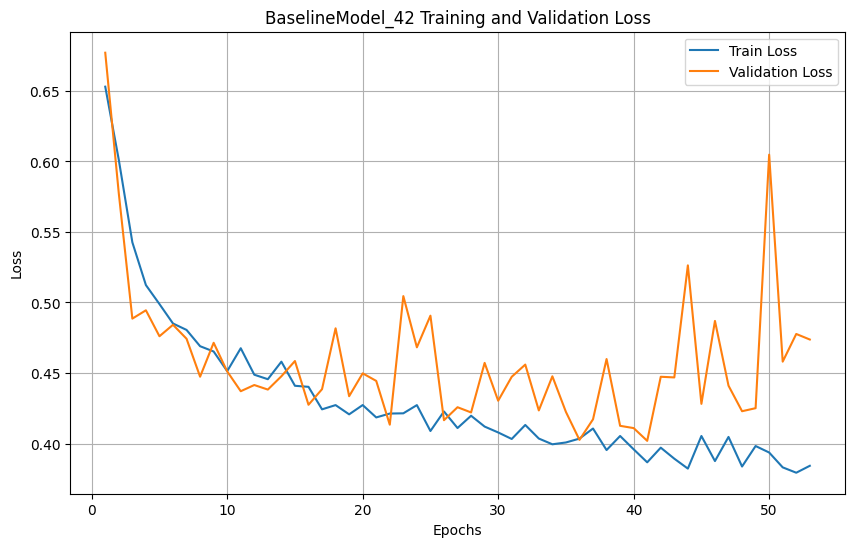

Model_1_42: Epoch 1/60
Model_1_42: Train Loss: 0.6637, Train Accuracy: 0.6087, train_f1: 0.4734
Model_1_42: Validation Loss: 0.6415, Validation Accuracy: 0.6456, Validation F1-Score: 0.6238
Model_1_42: Epoch 2/60
Model_1_42: Train Loss: 0.6307, Train Accuracy: 0.6498, train_f1: 0.5982
Model_1_42: Validation Loss: 0.7125, Validation Accuracy: 0.6266, Validation F1-Score: 0.4935
Model_1_42: No improvement for 1 epoch(s).
Model_1_42: Epoch 3/60
Model_1_42: Train Loss: 0.5946, Train Accuracy: 0.6787, train_f1: 0.6570
Model_1_42: Validation Loss: 0.6337, Validation Accuracy: 0.6709, Validation F1-Score: 0.5905
Model_1_42: No improvement for 2 epoch(s).
Model_1_42: Epoch 4/60
Model_1_42: Train Loss: 0.5584, Train Accuracy: 0.7136, train_f1: 0.6971
Model_1_42: Validation Loss: 0.6699, Validation Accuracy: 0.6899, Validation F1-Score: 0.6168
Model_1_42: No improvement for 3 epoch(s).
Model_1_42: Epoch 5/60
Model_1_42: Train Loss: 0.5360, Train Accuracy: 0.7369, train_f1: 0.7232
Model_1_42: Val

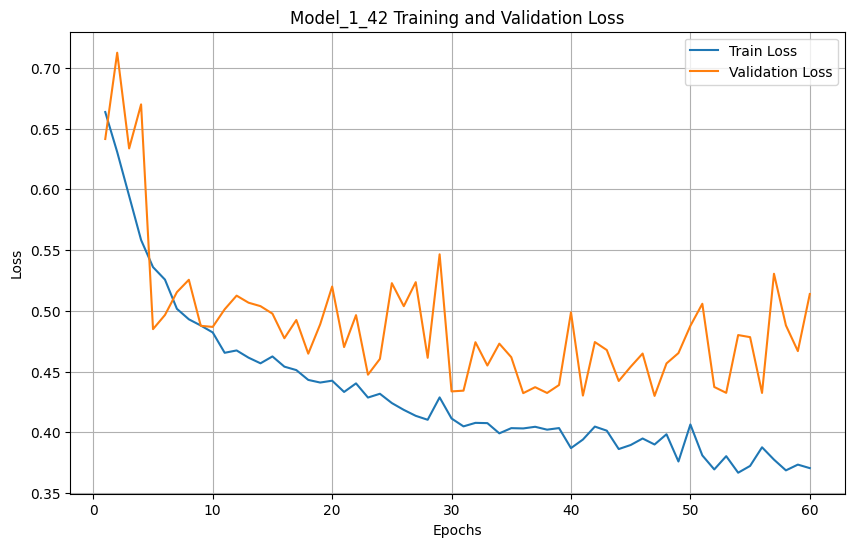

M2_42: Epoch 1/60
M2_42: Train Loss: 0.6549, Train Accuracy: 0.6202, train_f1: 0.5155
M2_42: Validation Loss: 0.6361, Validation Accuracy: 0.6646, Validation F1-Score: 0.6102
M2_42: Epoch 2/60
M2_42: Train Loss: 0.6222, Train Accuracy: 0.6544, train_f1: 0.6183
M2_42: Validation Loss: 0.6589, Validation Accuracy: 0.5696, Validation F1-Score: 0.3629
M2_42: No improvement for 1 epoch(s).
M2_42: Epoch 3/60
M2_42: Train Loss: 0.6075, Train Accuracy: 0.6756, train_f1: 0.6391
M2_42: Validation Loss: 0.6445, Validation Accuracy: 0.6582, Validation F1-Score: 0.5553
M2_42: No improvement for 2 epoch(s).
M2_42: Epoch 4/60
M2_42: Train Loss: 0.5687, Train Accuracy: 0.7185, train_f1: 0.6975
M2_42: Validation Loss: 0.5633, Validation Accuracy: 0.7215, Validation F1-Score: 0.7096
M2_42: Epoch 5/60
M2_42: Train Loss: 0.5526, Train Accuracy: 0.7275, train_f1: 0.7123
M2_42: Validation Loss: 0.5105, Validation Accuracy: 0.7215, Validation F1-Score: 0.7179
M2_42: Epoch 6/60
M2_42: Train Loss: 0.5248, Trai

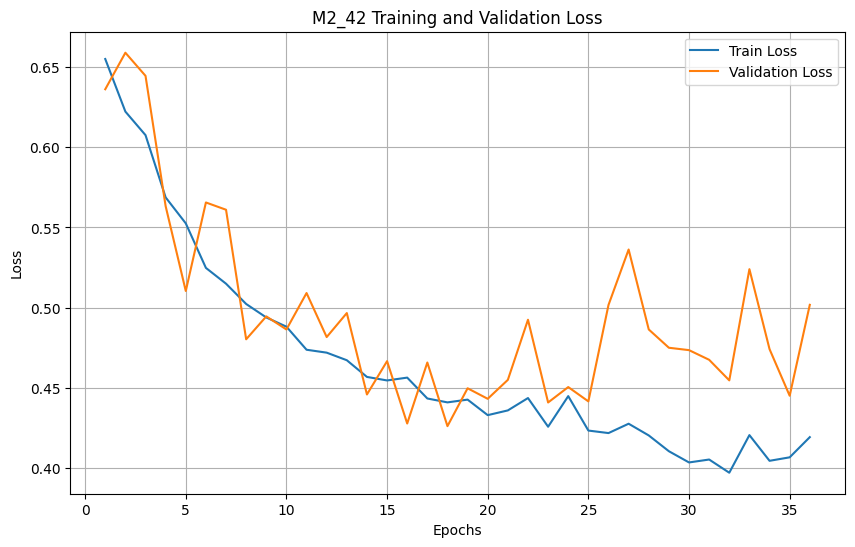

BaselineModel_457: Epoch 1/60
BaselineModel_457: Train Loss: 0.6489, Train Accuracy: 0.6206, train_f1: 0.5429
BaselineModel_457: Validation Loss: 0.7013, Validation Accuracy: 0.6329, Validation F1-Score: 0.5433
BaselineModel_457: Epoch 2/60
BaselineModel_457: Train Loss: 0.6113, Train Accuracy: 0.6631, train_f1: 0.6304
BaselineModel_457: Validation Loss: 0.6002, Validation Accuracy: 0.7025, Validation F1-Score: 0.6419
BaselineModel_457: Epoch 3/60
BaselineModel_457: Train Loss: 0.5632, Train Accuracy: 0.7188, train_f1: 0.6962
BaselineModel_457: Validation Loss: 0.5081, Validation Accuracy: 0.7405, Validation F1-Score: 0.7367
BaselineModel_457: Epoch 4/60
BaselineModel_457: Train Loss: 0.5255, Train Accuracy: 0.7502, train_f1: 0.7359
BaselineModel_457: Validation Loss: 0.4951, Validation Accuracy: 0.7848, Validation F1-Score: 0.7756
BaselineModel_457: Epoch 5/60
BaselineModel_457: Train Loss: 0.5111, Train Accuracy: 0.7631, train_f1: 0.7492
BaselineModel_457: Validation Loss: 0.5192, Va

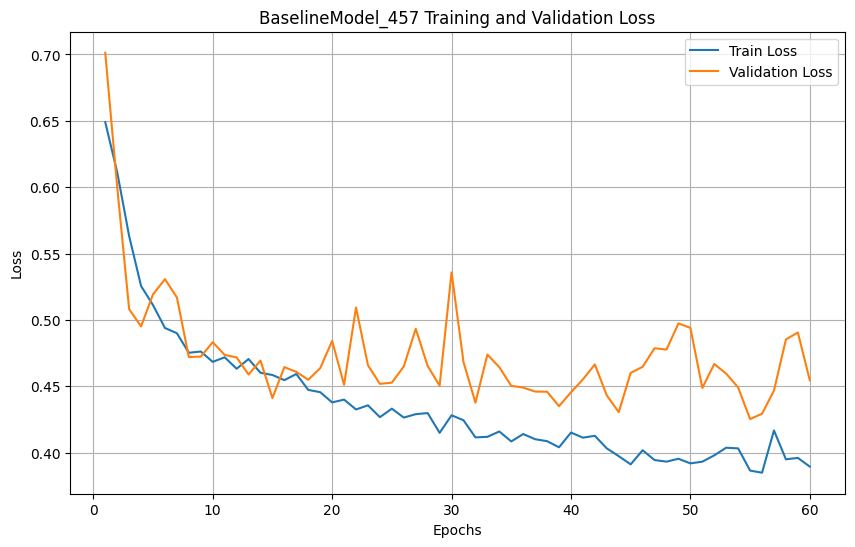

Model_1_457: Epoch 1/60
Model_1_457: Train Loss: 0.6748, Train Accuracy: 0.6017, train_f1: 0.4416
Model_1_457: Validation Loss: 0.6743, Validation Accuracy: 0.5823, Validation F1-Score: 0.3944
Model_1_457: Epoch 2/60
Model_1_457: Train Loss: 0.6342, Train Accuracy: 0.6495, train_f1: 0.6049
Model_1_457: Validation Loss: 0.5989, Validation Accuracy: 0.7278, Validation F1-Score: 0.7038
Model_1_457: Epoch 3/60
Model_1_457: Train Loss: 0.5867, Train Accuracy: 0.6983, train_f1: 0.6709
Model_1_457: Validation Loss: 0.5627, Validation Accuracy: 0.7405, Validation F1-Score: 0.7197
Model_1_457: Epoch 4/60
Model_1_457: Train Loss: 0.5469, Train Accuracy: 0.7373, train_f1: 0.7225
Model_1_457: Validation Loss: 0.5145, Validation Accuracy: 0.7658, Validation F1-Score: 0.7537
Model_1_457: Epoch 5/60
Model_1_457: Train Loss: 0.5266, Train Accuracy: 0.7505, train_f1: 0.7375
Model_1_457: Validation Loss: 0.4984, Validation Accuracy: 0.7722, Validation F1-Score: 0.7668
Model_1_457: Epoch 6/60
Model_1_457

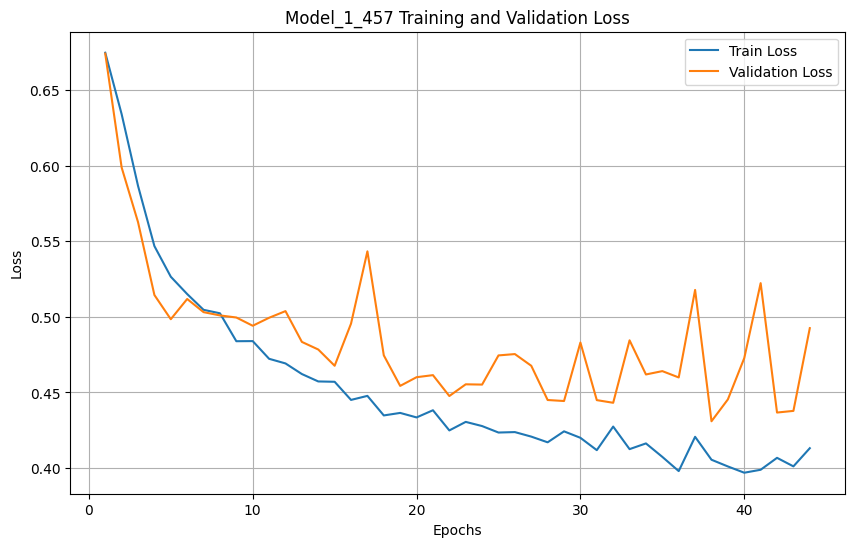

M2_457: Epoch 1/60
M2_457: Train Loss: 0.6630, Train Accuracy: 0.5990, train_f1: 0.5034
M2_457: Validation Loss: 0.6761, Validation Accuracy: 0.5696, Validation F1-Score: 0.3629
M2_457: Epoch 2/60
M2_457: Train Loss: 0.6318, Train Accuracy: 0.6505, train_f1: 0.6036
M2_457: Validation Loss: 0.5726, Validation Accuracy: 0.7405, Validation F1-Score: 0.7287
M2_457: Epoch 3/60
M2_457: Train Loss: 0.6040, Train Accuracy: 0.6746, train_f1: 0.6456
M2_457: Validation Loss: 0.6287, Validation Accuracy: 0.6139, Validation F1-Score: 0.4937
M2_457: No improvement for 1 epoch(s).
M2_457: Epoch 4/60
M2_457: Train Loss: 0.5863, Train Accuracy: 0.6944, train_f1: 0.6679
M2_457: Validation Loss: 0.6181, Validation Accuracy: 0.6709, Validation F1-Score: 0.5846
M2_457: No improvement for 2 epoch(s).
M2_457: Epoch 5/60
M2_457: Train Loss: 0.5417, Train Accuracy: 0.7373, train_f1: 0.7216
M2_457: Validation Loss: 0.6074, Validation Accuracy: 0.6772, Validation F1-Score: 0.6011
M2_457: No improvement for 3 epo

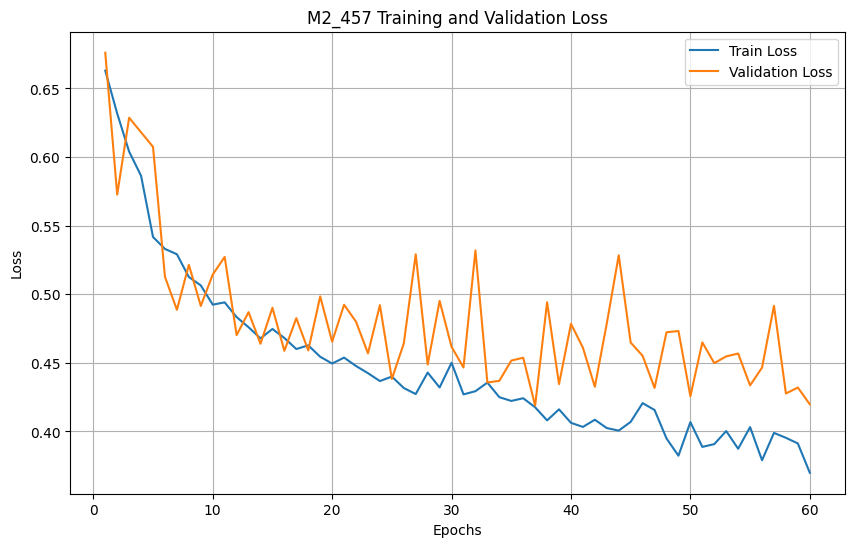

BaselineModel_999: Epoch 1/60
BaselineModel_999: Train Loss: 0.6502, Train Accuracy: 0.6153, train_f1: 0.5325
BaselineModel_999: Validation Loss: 0.6187, Validation Accuracy: 0.6646, Validation F1-Score: 0.6102
BaselineModel_999: Epoch 2/60
BaselineModel_999: Train Loss: 0.5743, Train Accuracy: 0.7021, train_f1: 0.6780
BaselineModel_999: Validation Loss: 0.5324, Validation Accuracy: 0.7468, Validation F1-Score: 0.7256
BaselineModel_999: Epoch 3/60
BaselineModel_999: Train Loss: 0.5353, Train Accuracy: 0.7366, train_f1: 0.7163
BaselineModel_999: Validation Loss: 0.5111, Validation Accuracy: 0.7342, Validation F1-Score: 0.7196
BaselineModel_999: No improvement for 1 epoch(s).
BaselineModel_999: Epoch 4/60
BaselineModel_999: Train Loss: 0.5179, Train Accuracy: 0.7564, train_f1: 0.7428
BaselineModel_999: Validation Loss: 0.5388, Validation Accuracy: 0.7405, Validation F1-Score: 0.6985
BaselineModel_999: No improvement for 2 epoch(s).
BaselineModel_999: Epoch 5/60
BaselineModel_999: Train L

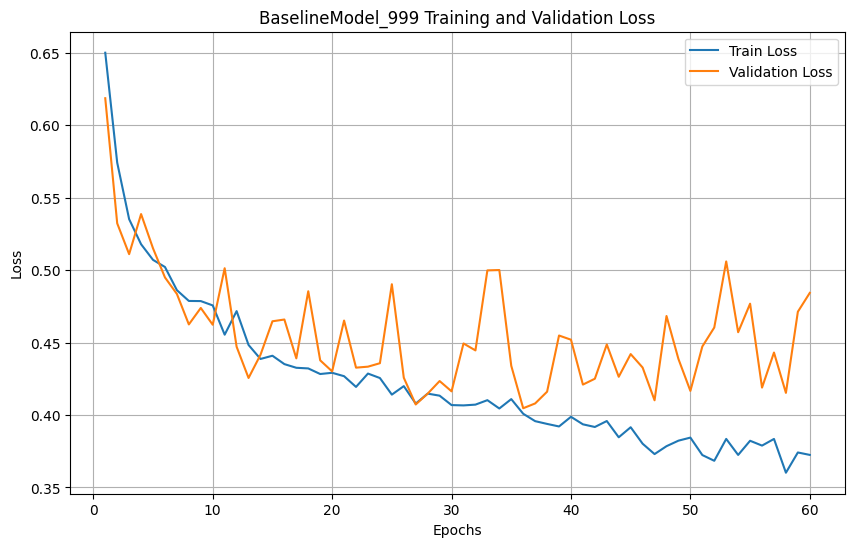

Model_1_999: Epoch 1/60
Model_1_999: Train Loss: 0.6638, Train Accuracy: 0.6098, train_f1: 0.4491
Model_1_999: Validation Loss: 0.6755, Validation Accuracy: 0.5696, Validation F1-Score: 0.3629
Model_1_999: Epoch 2/60
Model_1_999: Train Loss: 0.6428, Train Accuracy: 0.6199, train_f1: 0.5589
Model_1_999: Validation Loss: 0.6087, Validation Accuracy: 0.6772, Validation F1-Score: 0.6585
Model_1_999: Epoch 3/60
Model_1_999: Train Loss: 0.6014, Train Accuracy: 0.6711, train_f1: 0.6431
Model_1_999: Validation Loss: 0.5317, Validation Accuracy: 0.7215, Validation F1-Score: 0.6981
Model_1_999: Epoch 4/60
Model_1_999: Train Loss: 0.5526, Train Accuracy: 0.7293, train_f1: 0.7135
Model_1_999: Validation Loss: 0.5547, Validation Accuracy: 0.7532, Validation F1-Score: 0.7245
Model_1_999: Epoch 5/60
Model_1_999: Train Loss: 0.5337, Train Accuracy: 0.7446, train_f1: 0.7300
Model_1_999: Validation Loss: 0.5599, Validation Accuracy: 0.7532, Validation F1-Score: 0.7269
Model_1_999: Epoch 6/60
Model_1_999

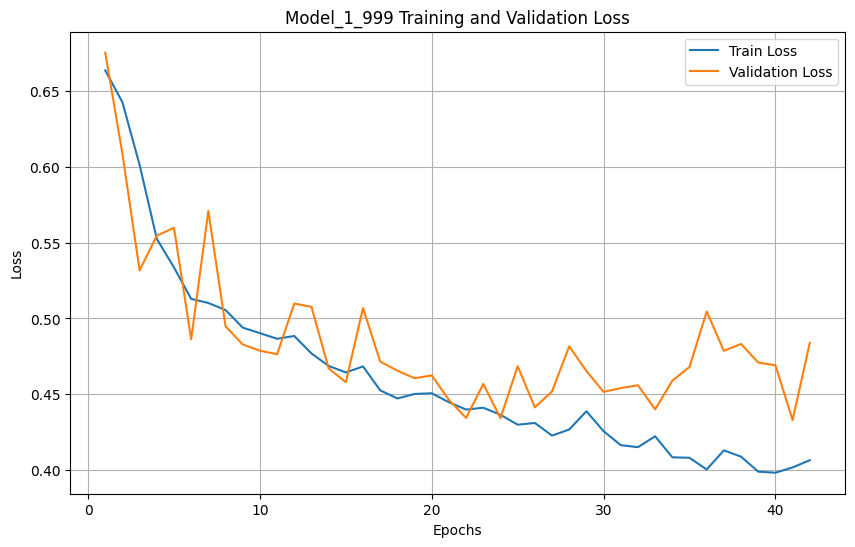

M2_999: Epoch 1/60
M2_999: Train Loss: 0.6736, Train Accuracy: 0.6003, train_f1: 0.4243
M2_999: Validation Loss: 0.6820, Validation Accuracy: 0.5696, Validation F1-Score: 0.3629
M2_999: Epoch 2/60
M2_999: Train Loss: 0.6627, Train Accuracy: 0.6098, train_f1: 0.4576
M2_999: Validation Loss: 0.6589, Validation Accuracy: 0.5823, Validation F1-Score: 0.5537
M2_999: Epoch 3/60
M2_999: Train Loss: 0.6283, Train Accuracy: 0.6540, train_f1: 0.6129
M2_999: Validation Loss: 0.6214, Validation Accuracy: 0.7152, Validation F1-Score: 0.7066
M2_999: Epoch 4/60
M2_999: Train Loss: 0.5935, Train Accuracy: 0.6962, train_f1: 0.6710
M2_999: Validation Loss: 0.5993, Validation Accuracy: 0.7025, Validation F1-Score: 0.6615
M2_999: No improvement for 1 epoch(s).
M2_999: Epoch 5/60
M2_999: Train Loss: 0.5524, Train Accuracy: 0.7341, train_f1: 0.7166
M2_999: Validation Loss: 0.5325, Validation Accuracy: 0.7532, Validation F1-Score: 0.7388
M2_999: Epoch 6/60
M2_999: Train Loss: 0.5376, Train Accuracy: 0.7470, 

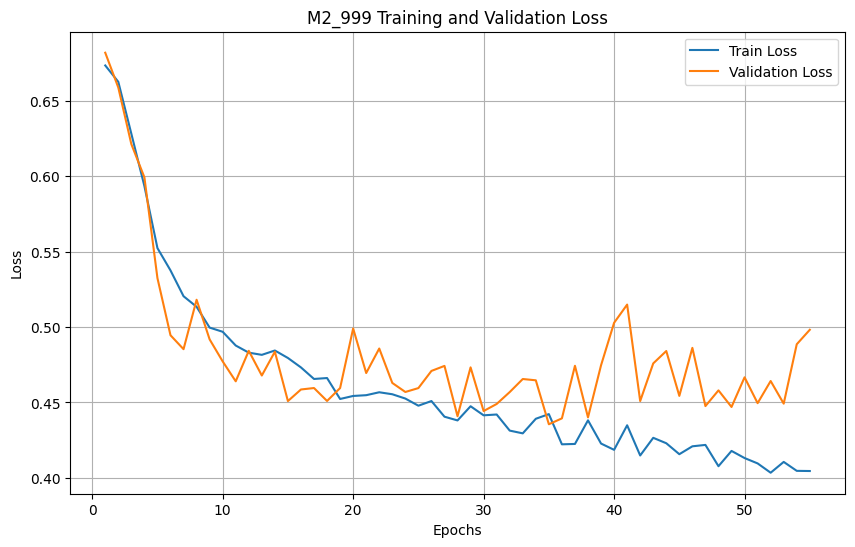

In [37]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seeds = [42, 457, 999]

metrics_summary = {
    BaselineModel.__name__ : {},
    Model_1.__name__: {},
    M2.__name__ : {}
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for seed in seeds:
    set_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Train and evaluate Baseline Model
    bl_model = BaselineModel(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim=bl_best_params["hidden_dim"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout=bl_best_params["dropout"]
    ).to(device)

    trained_bl_model, bl_metrics = train_and_evaluate(
        model=bl_model,
        model_name = generate_name(BaselineModel.__name__ , seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=bl_best_params["learning_rate"],
        weight_decay=bl_best_params["weight_decay"],
        save_model_path=f"{generate_name(BaselineModel.__name__, seed) }.pt",
        early_stopping_patience=20
    )
    metrics_summary[BaselineModel.__name__ ][seed] = bl_metrics


    # Train and evaluate Model 1
    model_1 = Model_1(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim_1=m1_best_params["hidden_dim_1"],
        hidden_dim_2=m1_best_params["hidden_dim_2"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout_rate_1=m1_best_params["dropout_rate_1"]
    ).to(device)

    trained_model_1, m1_metrics = train_and_evaluate(
        model=model_1,
        model_name = generate_name(Model_1.__name__ , seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=m1_best_params["learning_rate"],
        weight_decay=m1_best_params["weight_decay"],
        early_stopping_patience=20,
        save_model_path=f"{generate_name(Model_1.__name__, seed)}.pt"
    )

    metrics_summary[Model_1.__name__ ][seed] = m1_metrics

    # Train and evaluate Model 2
    model_2 = M2(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim=m2_best_params["hidden_dim"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout=m2_best_params["dropout"]
    ).to(device)

    trained_model_2, m2_metrics = train_and_evaluate(
        model=model_2,
        model_name=generate_name(M2.__name__, seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=m2_best_params["learning_rate"],
        weight_decay=m2_best_params["weight_decay"],
        early_stopping_patience=20,
        save_model_path=f"{generate_name(M2.__name__, seed)}.pt"
    )

    metrics_summary[M2.__name__][seed] = m2_metrics



In [38]:
f1_results = {}
for model in metrics_summary:
  f1_results[model] = []
  for seed in metrics_summary[model]:
    metrics = metrics_summary[model][seed]
    f1_results[model].append(metrics["val_f1"])

print("F1 results of models for all seeds:")
print(f1_results)


F1 results of models for all seeds:
{'BaselineModel': [0.8354372370120402, 0.8185993111366245, 0.8407258064516129], 'Model_1': [0.8239735919125233, 0.8292885638297872, 0.8345549738219895], 'M2': [0.8222722159730034, 0.8345549738219895, 0.827112462006079]}


In [39]:
import numpy as np

for model, f1_scores in f1_results.items():
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f"Model: {model}")
    print(f"Mean F1-macro: {mean_f1:.4f}")
    print(f"Standard Deviation of F1-macro: {std_f1:.4f}")
    print("-" * 20)

Model: BaselineModel
Mean F1-macro: 0.8316
Standard Deviation of F1-macro: 0.0094
--------------------
Model: Model_1
Mean F1-macro: 0.8293
Standard Deviation of F1-macro: 0.0043
--------------------
Model: M2
Mean F1-macro: 0.8280
Standard Deviation of F1-macro: 0.0051
--------------------


**QUICK SUMMARY:** All three models show similar results. The BaselineModel achieves a slightly higher mean F1-macro score but has a worse standard deviation compared to Model_1. Analyzing the learning curves reveals that the BaselineModel shows clear signs of overfitting, so adding more layers would not help. This is evident as the performance slightly decreases in Model_1 and M2.


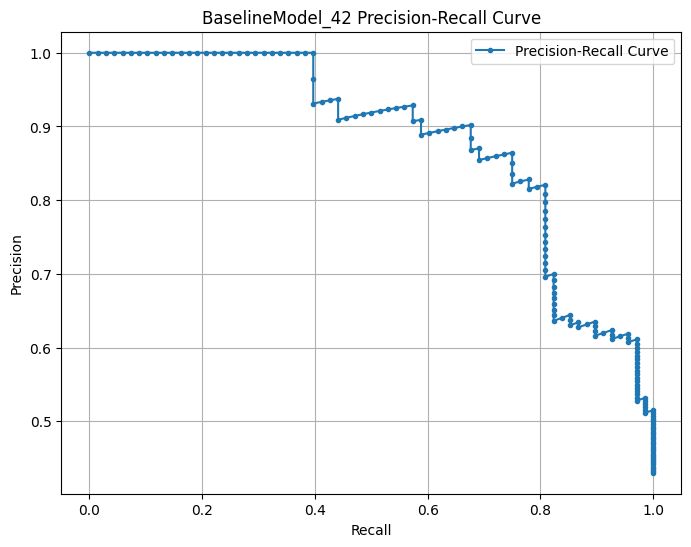

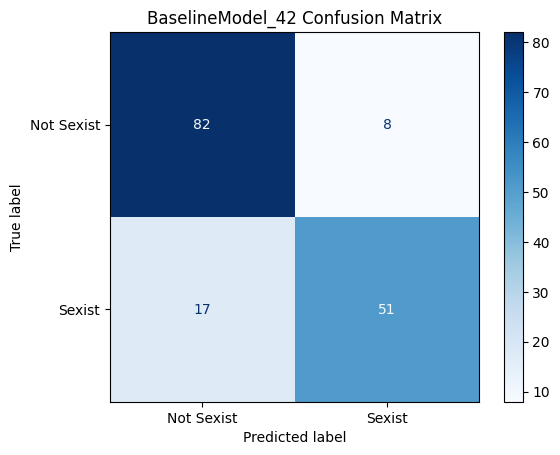



BaselineModel_42 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




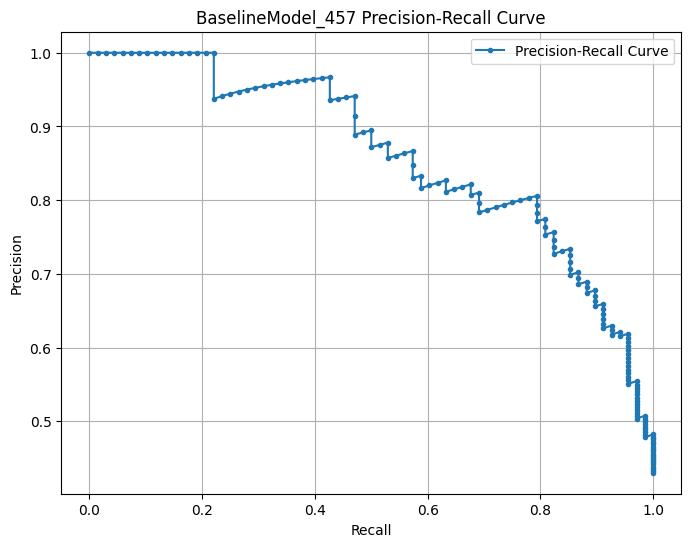

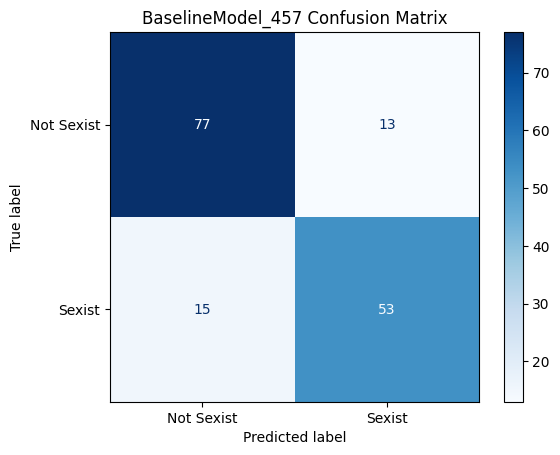



BaselineModel_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




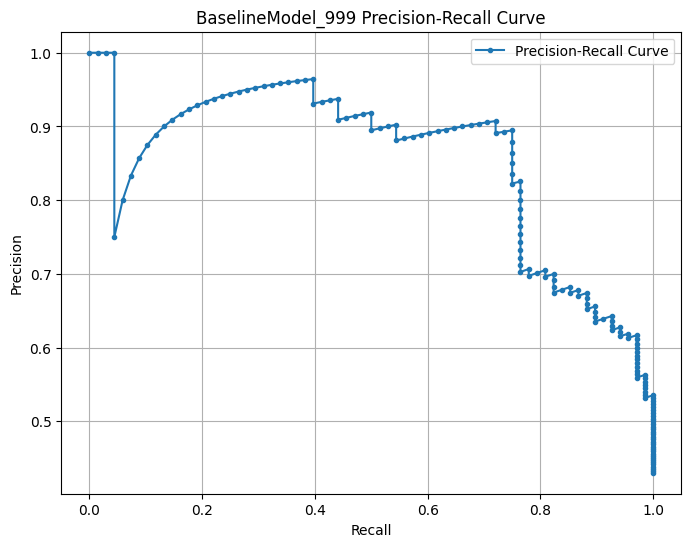

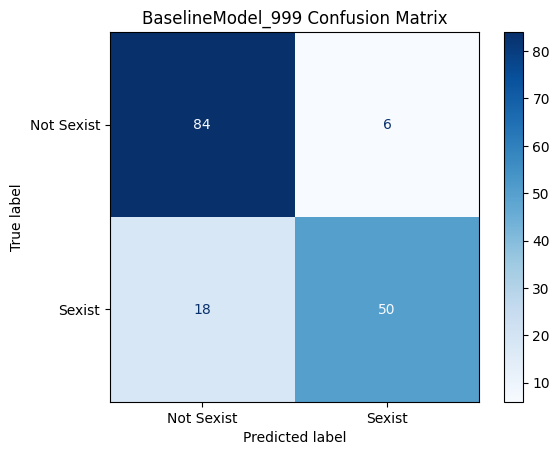



BaselineModel_999 Misclassified Samples:
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------




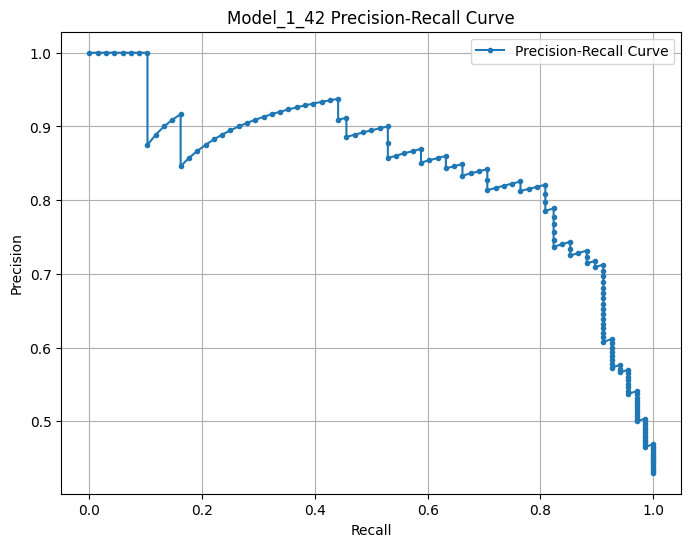

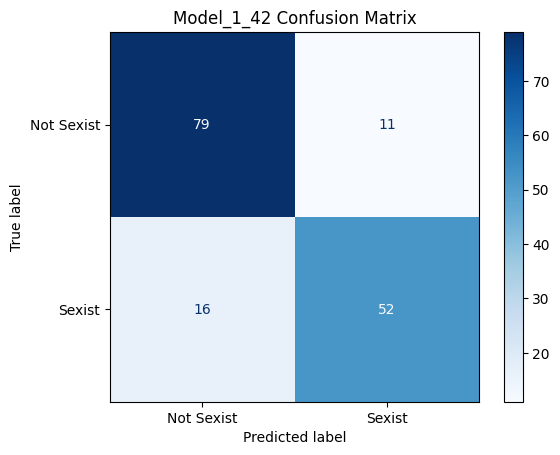



Model_1_42 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: collar between weareequal x    you already know it 🫵join our discord on how to join our exclusive giveaway
True Label: 0
Predicted Label: 1
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------




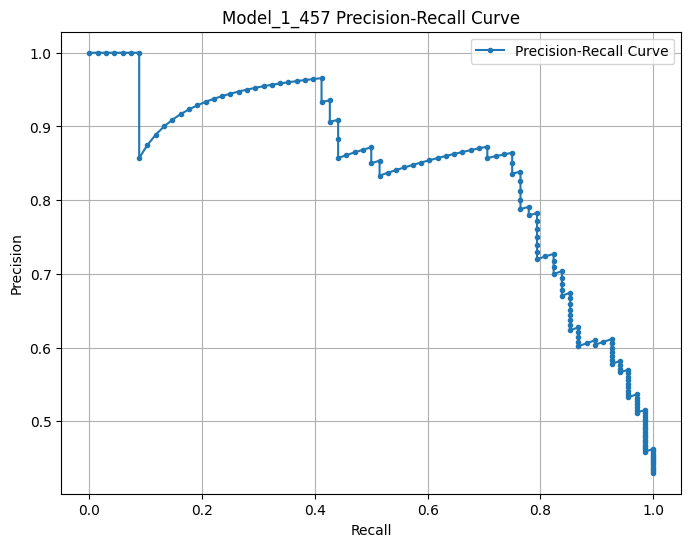

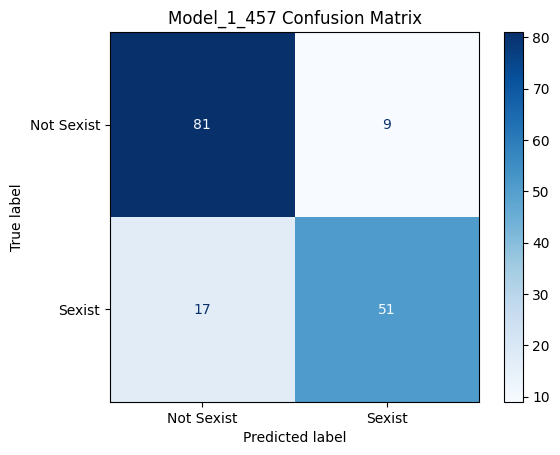



Model_1_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: wish all of you a very happy women day
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




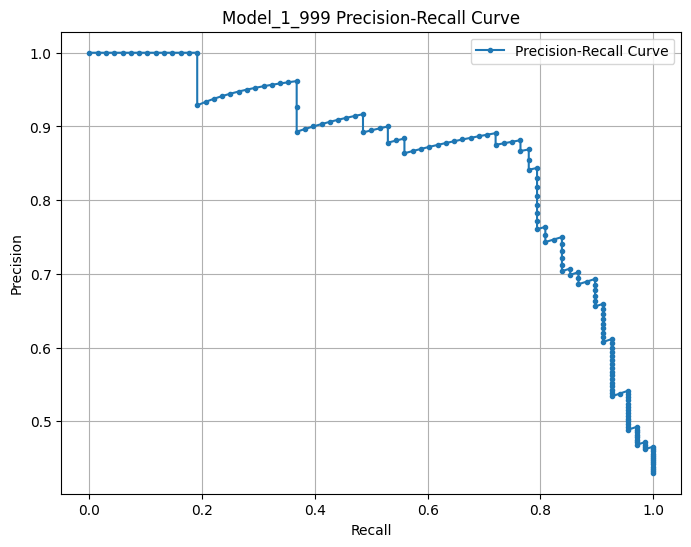

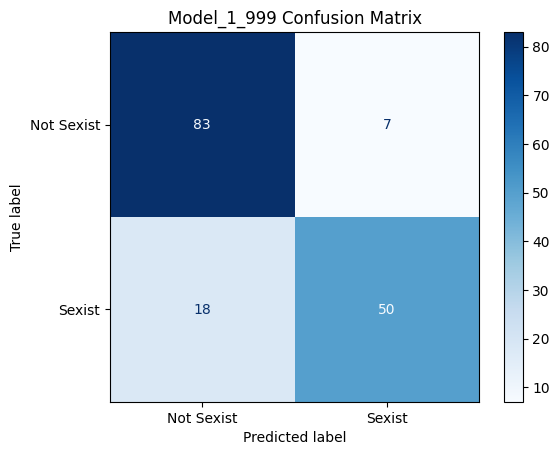



Model_1_999 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




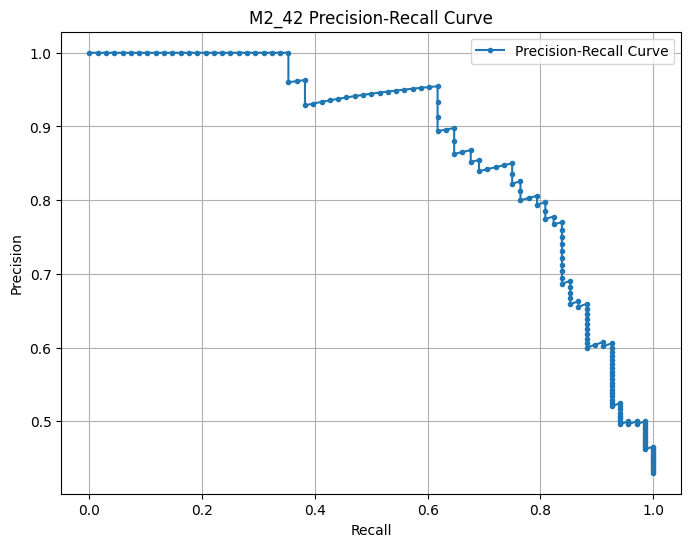

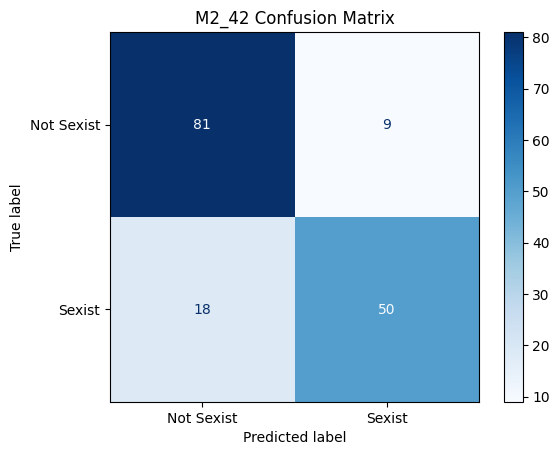



M2_42 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: this world would not last a day without woman
True Label: 0
Predicted Label: 1
--------------------




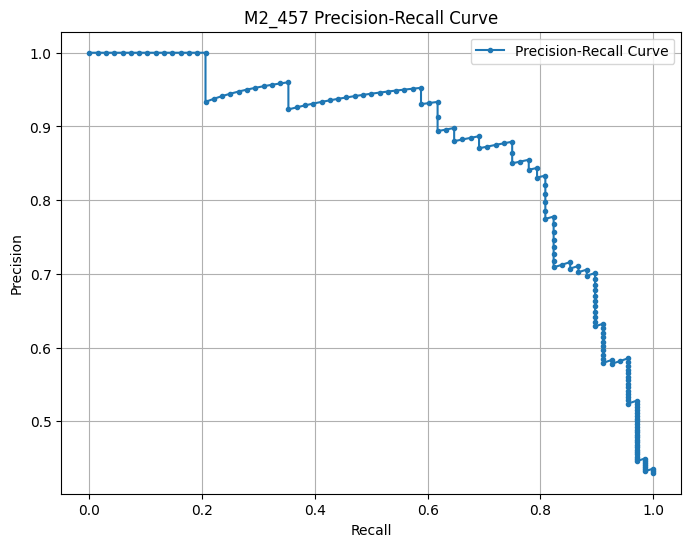

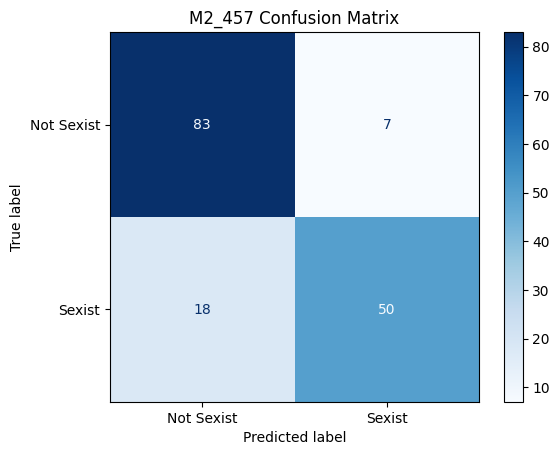



M2_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------




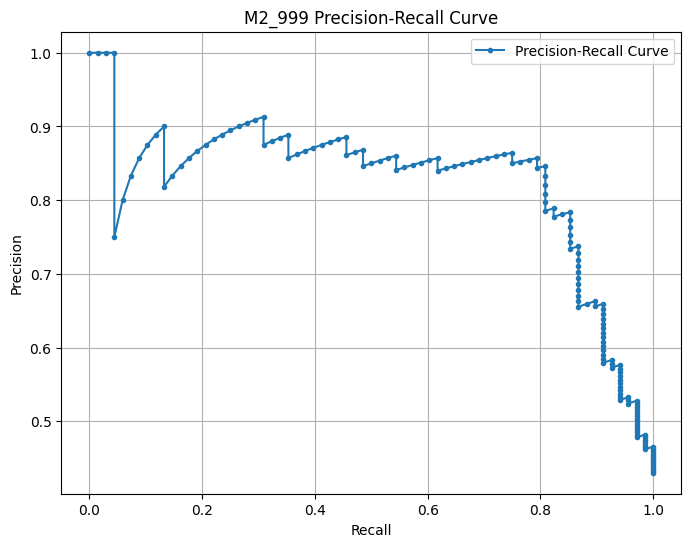

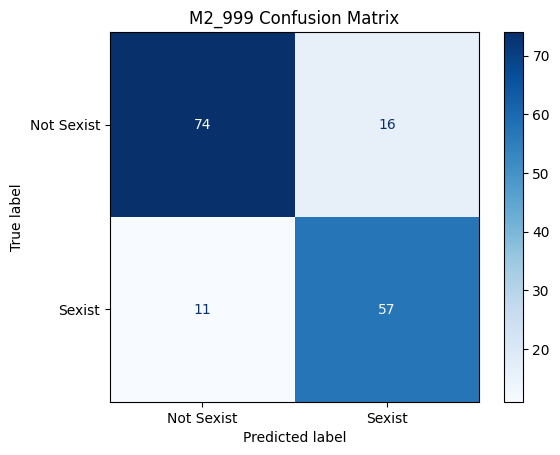



M2_999 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: collar between weareequal x    you already know it 🫵join our discord on how to join our exclusive giveaway
True Label: 0
Predicted Label: 1
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------


In [44]:
tweets_validation_data_df = pd.DataFrame({'tweet': data_validation_cleaned['tweet'].tolist()})
true_labels = data_validation_cleaned['hard_label_task1'].tolist()

for m in metrics_summary:
  for seed in metrics_summary[m]:
    metrics = metrics_summary[m][seed]
    prediction_scores = metrics['val_prediction_scores']
    perform_error_analysis(generate_name(m, seed), tweets_validation_data_df, true_labels= true_labels, predictions=np.array(prediction_scores))

We save the results in a df to further analyze.

In [41]:
predictions_df = data_validation_cleaned[['tweet','hard_label_task1']].copy()
predictions_df.rename(columns={'hard_label_task1': 'label'}, inplace=True)

for m in metrics_summary:
  for seed in metrics_summary[m]:
    preds = (np.array(metrics_summary[m][seed]['val_prediction_scores']) >= 0.5).astype('int')
    predictions_df[f"{m}_{seed}"] = preds

# Add majority vote for each model across all seeds
for m in metrics_summary:
    seed_columns = [f"{m}_{seed}" for seed in metrics_summary[m]]
    predictions_df[f"{m}_majority"] = predictions_df[seed_columns].mode(axis=1)[0]


# Add majority vote across all models
model_majority_columns = [f"{m}_majority" for m in metrics_summary]
predictions_df['all_models_majority'] = predictions_df[model_majority_columns].mode(axis=1)[0]


predictions_df.head(5)


,tweet,label,BaselineModel_42,BaselineModel_457,BaselineModel_999,Model_1_42,Model_1_457,Model_1_999,M2_42,M2_457,M2_999,BaselineModel_majority,Model_1_majority,M2_majority,all_models_majority
0,you should smile more love just pretend you re...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,she be right but the push be all in the opposi...,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,some man move my suitcase in the overhead lugg...,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,lol gamergate the go to boogieman maybe if the...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,to I this have the same negativity as gamergat...,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
predictions_df.to_pickle("lstm_results_1.pkl")

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
!pip install -U "huggingface_hub[cli]"


In [12]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score
import os

In [13]:
train_data = Dataset.from_pandas(data_training_cleaned)
validation_data = Dataset.from_pandas(data_validation_cleaned)
test_data = Dataset.from_pandas(data_test_cleaned)

In [14]:
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": acc}


In [ ]:
pretrained_models = {
    "cardiffnlp/twitter-roberta-base-hate": "cardiffnlp/twitter-roberta-base-hate",
}
seeds = [144, 256, 42]

## fine-tuning process

In [ ]:
#fine-tuning process: 
all_results = {}
best_models = {}

for model_name, tokenizer_name in pretrained_models.items():
    all_results[model_name] = {}
    for seed in seeds:
        print(f"\n{'='*50}")
        print(f"Starting training for {model_name} with seed {seed}")
        print(f"{'='*50}\n")

        print("1. Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        #tokenizing datasets
        def tokenize_function(examples):
            return tokenizer(examples['tweet'], truncation=True, padding='max_length', max_length=128)

        print("2. Preparing datasets...")
        tokenized_train = train_data.map(tokenize_function, batched=True)
        tokenized_val = validation_data.map(tokenize_function, batched=True)
        tokenized_test = test_data.map(tokenize_function, batched=True)
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        print("3. Loading model...")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
            id2label={0: 'NO', 1: 'YES'},
            label2id={'NO': 0, 'YES': 1}
        )
        
        print("4. Setting up training arguments...")
        training_args = TrainingArguments(
            output_dir=f"./trained_model/{model_name.replace('/', '_')}_seed_{seed}",
            learning_rate=2e-05,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=8,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            lr_scheduler_type='linear',
            load_best_model_at_end=True,
            save_total_limit=1,
            metric_for_best_model="f1",
            greater_is_better=True,
            report_to="none",
            seed=seed,
            warmup_ratio=0.1,
            logging_steps=100,
            logging_first_step=True
        )

        early_stopping_callback = EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping_callback]
        )

        print("6. Starting training...")
        try:
            train_output = trainer.train()
            print("Training completed successfully!")
            best_models[(model_name, seed)] = training_args.output_dir

            #evaluate on test set
            print("7. Evaluating on test set...")
            test_results = trainer.evaluate(tokenized_val)
            all_results[model_name][seed] = test_results


        except Exception as e:
            print(f"Error during training: {str(e)}")
            continue


Starting training for cardiffnlp/twitter-roberta-base-hate with seed 144

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 27794.22 examples/s]

3. Loading model...


4. Setting up training arguments...


/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6. Starting training...


  0%|          | 1/1440 [00:00<10:14,  2.34it/s]

{'loss': 0.6752, 'grad_norm': 12.345504760742188, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:43<09:42,  2.30it/s]

{'loss': 0.4714, 'grad_norm': 10.97596263885498, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:18<07:41,  2.73it/s]

{'eval_loss': 0.3447039723396301, 'eval_f1': 0.8642111724984654, 'eval_accuracy': 0.8670886075949367, 'eval_runtime': 1.2255, 'eval_samples_per_second': 128.923, 'eval_steps_per_second': 8.16, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:28<08:43,  2.37it/s]

{'loss': 0.425, 'grad_norm': 16.31563377380371, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:11<07:58,  2.38it/s]

{'loss': 0.3409, 'grad_norm': 18.828065872192383, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:37<06:26,  2.79it/s]

{'eval_loss': 0.3736947178840637, 'eval_f1': 0.8459843187115914, 'eval_accuracy': 0.8544303797468354, 'eval_runtime': 1.174, 'eval_samples_per_second': 134.587, 'eval_steps_per_second': 8.518, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:55<07:15,  2.39it/s]

{'loss': 0.2806, 'grad_norm': 13.984070777893066, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:37<06:32,  2.40it/s]

{'loss': 0.1938, 'grad_norm': 10.956353187561035, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:55<05:29,  2.73it/s]

{'eval_loss': 0.6178439259529114, 'eval_f1': 0.8291152930997188, 'eval_accuracy': 0.8417721518987342, 'eval_runtime': 1.1851, 'eval_samples_per_second': 133.322, 'eval_steps_per_second': 8.438, 'epoch': 3.0}


 38%|███▊      | 540/1440 [03:57<06:35,  2.27it/s]


{'train_runtime': 237.4696, 'train_samples_per_second': 96.686, 'train_steps_per_second': 6.064, 'train_loss': 0.3328779953497428, 'epoch': 3.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]



Starting training for cardiffnlp/twitter-roberta-base-hate with seed 256

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 21611.17 examples/s]

3. Loading model...


4. Setting up training arguments...


/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6. Starting training...


  0%|          | 1/1440 [00:00<10:19,  2.32it/s]

{'loss': 0.8676, 'grad_norm': 18.197982788085938, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:41<09:19,  2.40it/s]

{'loss': 0.4826, 'grad_norm': 12.644590377807617, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:16<07:41,  2.73it/s]

{'eval_loss': 0.36971214413642883, 'eval_f1': 0.8562448304383788, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.2156, 'eval_samples_per_second': 129.974, 'eval_steps_per_second': 8.226, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:26<08:51,  2.33it/s]

{'loss': 0.413, 'grad_norm': 6.8625569343566895, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:09<07:58,  2.38it/s]

{'loss': 0.3037, 'grad_norm': 24.788671493530273, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:35<06:28,  2.78it/s]

{'eval_loss': 0.37116679549217224, 'eval_f1': 0.8531350346459354, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1729, 'eval_samples_per_second': 134.703, 'eval_steps_per_second': 8.526, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:54<07:23,  2.35it/s]

{'loss': 0.2776, 'grad_norm': 11.7655611038208, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:36<06:30,  2.41it/s]

{'loss': 0.2198, 'grad_norm': 36.57221221923828, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:54<05:33,  2.70it/s]

{'eval_loss': 0.5354557037353516, 'eval_f1': 0.8522108843537415, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1871, 'eval_samples_per_second': 133.097, 'eval_steps_per_second': 8.424, 'epoch': 3.0}


 38%|███▊      | 540/1440 [03:56<06:34,  2.28it/s]


{'train_runtime': 236.4412, 'train_samples_per_second': 97.107, 'train_steps_per_second': 6.09, 'train_loss': 0.32692265488483285, 'epoch': 3.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]



Starting training for cardiffnlp/twitter-roberta-base-hate with seed 42

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 14717.94 examples/s]

3. Loading model...



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


4. Setting up training arguments...
6. Starting training...


  0%|          | 1/1440 [00:00<10:20,  2.32it/s]

{'loss': 0.4605, 'grad_norm': 15.699357986450195, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:42<09:29,  2.35it/s]

{'loss': 0.4816, 'grad_norm': 10.504803657531738, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:17<07:37,  2.75it/s]

{'eval_loss': 0.3893112242221832, 'eval_f1': 0.8284043441938178, 'eval_accuracy': 0.8354430379746836, 'eval_runtime': 1.2307, 'eval_samples_per_second': 128.383, 'eval_steps_per_second': 8.126, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:27<08:37,  2.40it/s]

{'loss': 0.4224, 'grad_norm': 10.158513069152832, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:09<07:51,  2.42it/s]

{'loss': 0.3353, 'grad_norm': 10.803266525268555, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:36<06:38,  2.71it/s]

{'eval_loss': 0.33883005380630493, 'eval_f1': 0.8680033416875522, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 1.1851, 'eval_samples_per_second': 133.319, 'eval_steps_per_second': 8.438, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:55<07:22,  2.35it/s]

{'loss': 0.2864, 'grad_norm': 1.5604100227355957, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:38<06:36,  2.37it/s]

{'loss': 0.2231, 'grad_norm': 14.002696990966797, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:56<05:25,  2.76it/s]

{'eval_loss': 0.4200916886329651, 'eval_f1': 0.869313482216708, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 1.182, 'eval_samples_per_second': 133.674, 'eval_steps_per_second': 8.46, 'epoch': 3.0}


 42%|████▏     | 600/1440 [04:23<05:55,  2.37it/s]

{'loss': 0.1747, 'grad_norm': 13.311227798461914, 'learning_rate': 1.2962962962962964e-05, 'epoch': 3.33}


 49%|████▊     | 700/1440 [05:05<05:12,  2.37it/s]

{'loss': 0.1121, 'grad_norm': 4.350480556488037, 'learning_rate': 1.1419753086419753e-05, 'epoch': 3.89}


 50%|█████     | 720/1440 [05:14<04:20,  2.77it/s]

{'eval_loss': 0.7836160063743591, 'eval_f1': 0.8548036758563073, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1665, 'eval_samples_per_second': 135.444, 'eval_steps_per_second': 8.572, 'epoch': 4.0}


 50%|█████     | 720/1440 [05:17<05:17,  2.27it/s]


{'train_runtime': 316.9387, 'train_samples_per_second': 72.443, 'train_steps_per_second': 4.543, 'train_loss': 0.2842117879125807, 'epoch': 4.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


In [ ]:


print("\n--- Detailed Evaluation Results ---")
for model_name, seed_results in all_results.items():
    print(f"\nModel: {model_name}")
    f1_scores = []
    for seed, results in seed_results.items():
        f1 = results['eval_f1']
        f1_scores.append(f1)
        print(f"  Seed {seed}: F1 Score = {f1:.4f}")

    if f1_scores:
        avg_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        print(f"  Average F1 Score (across seeds): {avg_f1:.4f}")
        print(f"  Standard Deviation of F1 Scores: {std_f1:.4f}")


    else:
        print("  No successful evaluations for this model.")

print("\n--- Paths to the Best Models ---")
for (model_name, seed), path in best_models.items():
    print(f"Best model for {model_name} with seed {seed}: {path}")


--- Detailed Evaluation Results ---

Model: cardiffnlp/twitter-roberta-base-hate
  Seed 144: F1 Score = 0.8642
  Seed 256: F1 Score = 0.8562
  Seed 42: F1 Score = 0.8693
  Average F1 Score (across seeds): 0.8633
  Standard Deviation of F1 Scores: 0.0054

--- Paths to the Best Models ---
Best model for cardiffnlp/twitter-roberta-base-hate with seed 144: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_144
Best model for cardiffnlp/twitter-roberta-base-hate with seed 256: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_256
Best model for cardiffnlp/twitter-roberta-base-hate with seed 42: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_42


## validation and test set evaluation:

Processing model: cardiffnlp_twitter-roberta-base-hate_seed_42 using checkpoint: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_42/checkpoint-540


/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/3810362187.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/10 [00:00<?, ?it/s]

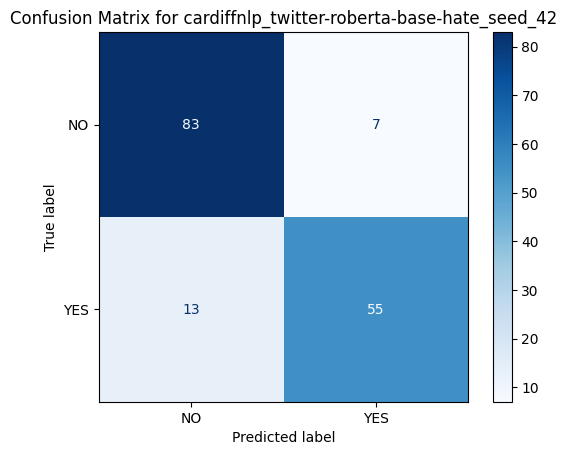


False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_42:
                                                 tweet  label  predicted_label
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
32   gynocentrism and androcentrism if you want to ...      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-hate_seed_42:
                                                 tweet  label  predicted_label
7                    get twitter harass for pro choice      1                0
24                             raise taxis and control      1       

/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/3810362187.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/10 [00:00<?, ?it/s]

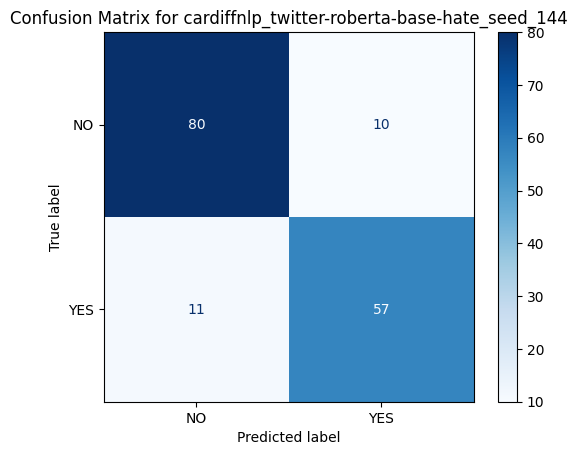


False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_144:
                                                 tweet  label  predicted_label
6    show off the man spend his money help the econ...      0                1
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
33   an androgynous mind be not a male mind it be a...      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
66   also this may make people call I sexist but I ...      0                1
96   the reason she say its mindless be because it ...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-ha

/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/3810362187.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/10 [00:00<?, ?it/s]

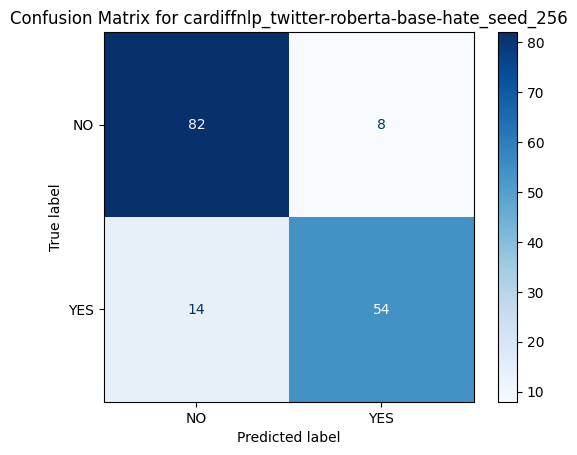


False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_256:
                                                 tweet  label  predicted_label
6    show off the man spend his money help the econ...      0                1
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
96   the reason she say its mindless be because it ...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-hate_seed_256:
                                                 tweet  label  predicted_label
7                    get twitter harass for pro choice      1     

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


base_dir = './trained_model'
models = [
    "cardiffnlp_twitter-roberta-base-hate_seed_42",
    "cardiffnlp_twitter-roberta-base-hate_seed_144",
    "cardiffnlp_twitter-roberta-base-hate_seed_256"
]

#initialize the final DataFrame
df_columns = ["tweet", "label"] + [f"{model}_pred" for model in models]
final_df = pd.DataFrame(columns=df_columns)

#function to find the latest checkpoint in a directory
def find_latest_checkpoint(model_path):
    checkpoints = [d for d in os.listdir(model_path) if d.startswith("checkpoint-")]
    latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
    return os.path.join(model_path, latest_checkpoint)

predictions_dict = {}
for model_name in models:
    model_path = os.path.join(base_dir, model_name)
    checkpoint_path = find_latest_checkpoint(model_path)
    print(f"Processing model: {model_name} using checkpoint: {checkpoint_path}")

   
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, trust_remote_code=True)

    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=checkpoint_path,
            per_device_eval_batch_size=16,
            report_to="none"
        ),
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    
    predictions = trainer.predict(tokenized_val)
    preds = np.argmax(predictions.predictions, axis=-1)
    predictions_dict[model_name] = preds

    # Compute confusion matrix
    cm = confusion_matrix(tokenized_val['label'], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    
    tokenized_val_df = pd.DataFrame({
        "tweet": tokenized_val["tweet"],
        "label": tokenized_val["label"]
    })

    #print False Positives and False Negatives
    fp_rows = tokenized_val_df[(tokenized_val_df["label"] == 0) & (preds == 1)]
    fn_rows = tokenized_val_df[(tokenized_val_df["label"] == 1) & (preds == 0)]

    print(f"\nFalse Positive rows for {model_name}:")
    print(fp_rows.assign(predicted_label=1)[["tweet", "label", "predicted_label"]])

    print(f"\nFalse Negative rows for {model_name}:")
    print(fn_rows.assign(predicted_label=0)[["tweet", "label", "predicted_label"]])

#populate the DataFrame
final_df["tweet"] = tokenized_val["tweet"]
final_df["label"] = tokenized_val["label"]
for model_name in models:
    final_df[f"{model_name}_pred"] = predictions_dict[model_name]

#   compute major voting
preds_array = np.array([predictions_dict[model] for model in models])
major_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=preds_array)
final_df["major_vote_cardiffnlp_twitter-roberta-base-hate"] = major_vote

#save the final DataFrame
output_path = os.path.join(base_dir, "final_predictions_1.pkl")
final_df.to_pickle(output_path)
print(f"Final DataFrame saved at {output_path}")


In [ ]:
print(final_df.head())

                                               tweet  label  \
0  you should smile more love just pretend you re...      0   
1  she be right but the push be all in the opposi...      1   
2  some man move my suitcase in the overhead lugg...      1   
3  lol gamergate the go to boogieman maybe if the...      0   
4  to I this have the same negativity as gamergat...      0   

   cardiffnlp_twitter-roberta-base-hate_seed_42_pred  \
0                                                  0   
1                                                  1   
2                                                  1   
3                                                  0   
4                                                  0   

   cardiffnlp_twitter-roberta-base-hate_seed_144_pred  \
0                                                  0    
1                                                  1    
2                                                  1    
3                                                  0    


Processing model: cardiffnlp_twitter-roberta-base-hate_seed_42
Using checkpoint: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_42/checkpoint-540


/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/645795713.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/18 [00:00<?, ?it/s]


Metrics for cardiffnlp_twitter-roberta-base-hate_seed_42:
F1 Score: 0.8327
Accuracy: 0.8322
--------------------------------------------------


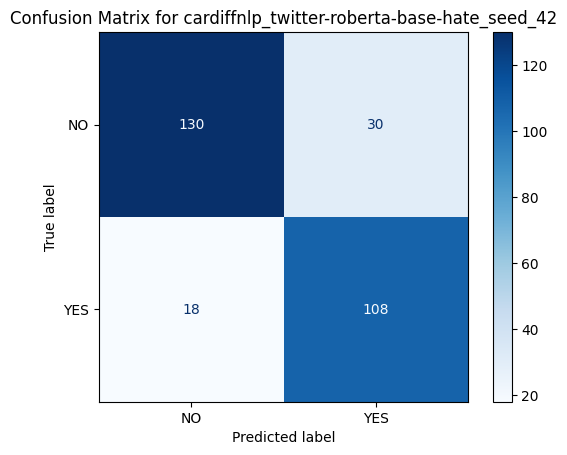


Processing model: cardiffnlp_twitter-roberta-base-hate_seed_144
Using checkpoint: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_144/checkpoint-180


/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/645795713.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/18 [00:00<?, ?it/s]


Metrics for cardiffnlp_twitter-roberta-base-hate_seed_144:
F1 Score: 0.8327
Accuracy: 0.8322
--------------------------------------------------


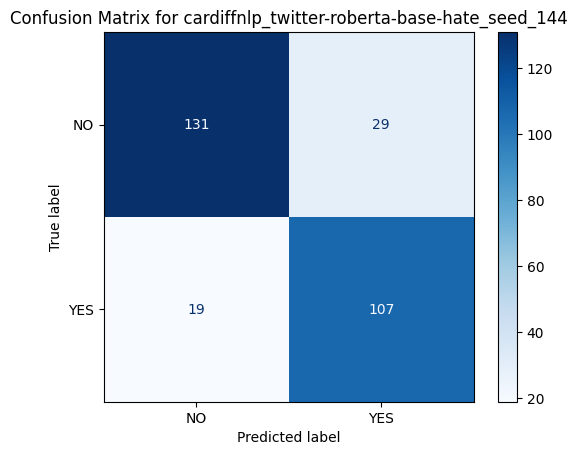


Processing model: cardiffnlp_twitter-roberta-base-hate_seed_256
Using checkpoint: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_256/checkpoint-180


/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_76355/645795713.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/18 [00:00<?, ?it/s]


Metrics for cardiffnlp_twitter-roberta-base-hate_seed_256:
F1 Score: 0.8354
Accuracy: 0.8357
--------------------------------------------------


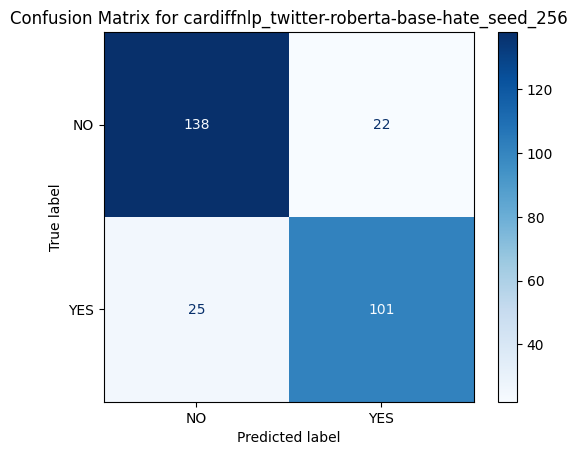

In [ ]:
#metrics for test set
base_dir = './trained_model'
models = [
    "cardiffnlp_twitter-roberta-base-hate_seed_42",
    "cardiffnlp_twitter-roberta-base-hate_seed_144",
    "cardiffnlp_twitter-roberta-base-hate_seed_256"
]


def find_latest_checkpoint(model_path):
    checkpoints = [d for d in os.listdir(model_path) if d.startswith("checkpoint-")]
    latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
    return os.path.join(model_path, latest_checkpoint)


def print_metrics(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nMetrics for {model_name}:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-" * 50)


predictions_dict_test = {}
for model_name in models:
    model_path = os.path.join(base_dir, model_name)
    checkpoint_path = find_latest_checkpoint(model_path)
    print(f"\nProcessing model: {model_name}")
    print(f"Using checkpoint: {checkpoint_path}")

  
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, trust_remote_code=True)


    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=checkpoint_path,
            per_device_eval_batch_size=16,
            report_to="none"
        ),
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    
    predictions = trainer.predict(tokenized_test)
    preds = np.argmax(predictions.predictions, axis=-1)
    predictions_dict_test[model_name] = preds
    print_metrics(tokenized_test['label'], preds, model_name)

    
    cm = confusion_matrix(tokenized_test['label'], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



In [ ]:
#Combining Validation Set Predictions from Transformer and LSTM Models for Error Analysis:
import pandas as pd


with open('final_predictions_1.pkl', 'rb') as file:
    final_predictions = pd.read_pickle(file)


with open('lstm_results_1.pkl', 'rb') as file:
    lstm_results = pd.read_pickle(file)


result = pd.merge(final_predictions, lstm_results, on=['tweet', 'label'], how='outer')
columns_to_keep = [
        'tweet',
        'label',
        'major_vote_cardiffnlp_twitter-roberta-base-hate',
        'BaselineModel_majority',
        'Model_1_majority',
        'M2_majority',

    ]
filtered_result = result[columns_to_keep]




common_error_rows = filtered_result[
    (filtered_result['label'] != filtered_result['major_vote_cardiffnlp_twitter-roberta-base-hate']) &
    (filtered_result['label'] != filtered_result['BaselineModel_majority']) &
    (filtered_result['label'] != filtered_result['Model_1_majority']) &
    (filtered_result['label'] != filtered_result['M2_majority'])

]
incompatible_rows = filtered_result[~(
    (filtered_result['label'] == filtered_result['major_vote_cardiffnlp_twitter-roberta-base-hate']) &
    (filtered_result['label'] == filtered_result['BaselineModel_majority']) &
    (filtered_result['label'] == filtered_result['Model_1_majority']) &
    (filtered_result['label'] == filtered_result['M2_majority'])
) & ~filtered_result.index.isin(common_error_rows.index)]
print(incompatible_rows.shape)
print(common_error_rows.shape)


(28, 6)
(10, 6)


In [2]:
from IPython.display import display
from IPython.core.display import HTML
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Render the DataFrame as an HTML table

display(HTML(common_error_rows.to_html(index=False, max_rows=None, max_cols=None)))




tweet,label,major_vote_cardiffnlp_twitter-roberta-base-hate,BaselineModel_majority,Model_1_majority,M2_majority
at first I be scared of he but after some stalking I find out about his artistic side then I realize he can be sweet and salty like a good treat he garden tooabout as good as a man can get,1,0,0,0,0
freedom convoy toronto wave provide flagtheyre live in the wrong decade,1,0,0,0,0
get twitter harass for pro choice,1,0,0,0,0
its call identity politic and subversive culture yes they be try to spend cultural norm of what they view as traditionalbeauty standard by attempt to redefine what constitute attractive and display controversial image in order to virtue signal,1,0,0,0,0
just go cook for your husband and shut everyone make mistakeshow quickly people forget just the other day he have a fantastic ucl run and assist haaretz in the ucl finalyou show praise on he do not you,1,0,0,0,0
nearly 10 of student will encounter sexual misconduct at school to5b9hs39w,1,0,0,0,0
raise taxis and control,1,0,0,0,0
talkie centricidehe scream french person raise by static family just like I frfrha may 68 poster in his roombitche about absolutely everything like only a true french wouldancom listen to this banner and its either katiusha or lament de st jean no between,1,0,0,0,0
this be your reminder that you can be child woman without have to be a workaholic career climber to compensate as capitalist medium suggest neither motherhood nor employment status define your worth,0,1,1,1,1
you should take a getting pitch class,1,0,0,0,0


In [3]:

display(HTML(incompatible_rows.to_html(index=False, max_rows=None, max_cols=None)))




tweet,label,major_vote_cardiffnlp_twitter-roberta-base-hate,BaselineModel_majority,Model_1_majority,M2_majority
18yearly female kill in brooklyn home boyfriend in custody,1,0,1,0,1
I m debate do a feminization clip series for all my new issue to help they learn how to feminine,1,0,1,0,0
I m not fond of the feminization of his character either I mean each to their own but he s masculine not in a toxic way and gorgeous to I I m do not dream about he pregnant very popular in fiction locate or in lingerie also popular and I do not see he submissive,1,1,1,0,1
I mean the pitcher netflix be ass and not because see oe whatever the pitcher book be already anti war pro choice woman empowerment etc but the arc of jennifer be boring as shit and nilfgardian armour look like scrum,0,1,0,0,1
I sincerely wish the we be this progressive on women right,1,1,0,0,0
I think we be too what happen to long haired attractive guy mer,0,0,1,1,1
also this may make people call I sexist but I m sorry I want to see obi wan spend his time with a young luke and see how their bond grow over the year especially much to the anger of owen elias relationship with obi wan be through the knowledge of her father,0,0,1,0,1
an androgynous mind be not a male mind it be a mind attend to the full range of human experience include the invisible life of woman,0,0,1,1,1
be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more,0,0,1,1,0
bitch a maker mark bottle you have see a doctor after that have be in ya,0,1,0,1,0


# Our analysis of the models' predictions is ultimately based on educated guesses. We cannot fully comprehend the exact reasoning behind the model's decisions. Even techniques, like visualizing attention mechanisms, can only provide clues or partial insights into the model's behavior rather than a definitive explanation.

# Analysis of Common Errors (All Models Wrong)

The common error rows represent tweets where our analysis showed that all models, whether LSTM-based or transformer, failed to predict the correct label. These errors highlight inherent difficulties in certain tweets that even different model architectures struggle to overcome. Here's our analysis of potential reasons:

### Ambiguous Language and Context

Many tweets exhibit language that can be interpreted in multiple ways depending on the context. Words and phrases, such as "pro-choice," can signify either sexist or non-sexist sentiments. Sarcasm, irony, and humor are especially challenging for NLP models to decode without deeper world knowledge.

**Example:**  
*“get twitter harass for pro choice”* (labeled as sexist, but models predicted non-sexist) – This tweet seems to reference sexism indirectly, but the lack of explicit sexist language may have prevented models from identifying the implied connection to harassment.

---

### Indirect or Complex Sexism

Some tweets express sexism in subtle or indirect ways, relying on stereotypes, cultural references, or implicit biases. These nuances are challenging for models unless they are specifically trained to detect such subtleties.

**Example:**  
*“at first I be scared of he but after some stalking I find out about his artistic side then I realize he can be sweet and salty like a good treat he garden tooabout as good as a man can get”* (labeled as sexist, but models predicted non-sexist) – This tweet might invoke the stereotype that men are valued for certain traits, but the expression is indirect and roundabout.

---

### Data Labeling Challenges

The labeling process for sexist or non-sexist tweets is inherently subjective. Even with multiple annotators, disagreements or inconsistencies can arise, especially with borderline cases. These errors may stem from tweets that hover on the edge of sexism or from instances where annotators struggled to reach a consensus.

---

### Figurative Language and Idioms

Tweets often employ figurative language, such as metaphors or idioms, which are difficult for models to interpret literally.

**Example:**  
*“raise taxis and control”* (labeled as sexist, but models predicted non-sexist) – This likely contains an idiomatic expression that the models failed to understand in its intended sense.

---

### Challenges in Interpreting Informal and Fragmented Tweets

Tweets are often written informally, with little attention to structure or readability, making them ambiguous and challenging to interpret. This informality, combined with their brevity, frequently omits critical contextual cues that are essential for understanding intent. Models trained on individual tweets may struggle to classify such messages accurately without additional context or background.

**Example:**  
*“freedom convoy toronto wave provide flagtheyre live in the wrong decade”* (labeled as sexist, but models predicted non-sexist) – The fragmented structure and vague wording of the tweet hinder comprehension. Without further context or explanation, it is difficult to determine why it might be classified as sexist.


# Analysis of Errors Where Models Disagreed

 The incompatible rows are cases where at least one model got the prediction correct, but not all. These instances highlight the differences in how each model has learned to interpret language:

 ### Model Strengths and Weaknesses

 Different model architectures have different strengths. The LSTM-based models might be better at capturing sequential dependencies within a tweet, while the transformer might excel at understanding long-range relationships and context. These differences lead to variations in their predictions.

 ---

 ### Sensitivity to Specific Words or Phrases

 Some models might be more sensitive to certain keywords or phrases that they've learned to associate strongly with sexism or non-sexism. This can lead to disagreements when those specific words are present but used in an unusual context.

 ---

 ### Generalization Ability
 The transformer model, being pre-trained on a massive dataset, might have better generalization ability. It could be better at handling unseen combinations of words or phrases. However, it might also be more susceptible to biases present in its pre-training data. The transformer's extensive pre-training on a vast corpus of text, specifically for hate speech detection in this case, likely contributes to its ability to generalize to new and unseen language patterns.

 ---

 ### Hyperparameter Tuning

The variations in model behavior can be attributed to differences in the number of layers and hyperparameter tuning during training. Specifically, both Model_1 and M2 have an additional layer compared to the baseline model. However, Model_1 features distinct hidden dimensions for each layer, whereas M2 employs the same hidden dimension across all layers. These architectural differences likely contribute to the observed performance variations between the baseline, Model_1, and M2.

> ## Some examples:
>
> ---
>
> ### **Tweet :**  
> *"yo radical republicans & member of the patriarchy we be just getting start if you think summer 2020 be light wait until you see half the country in the street in 2022 you do not try to take away bodily autonomy of 175 million people out a large dose of good trouble"*  
>
> - **Label:** 0 (non-sexist)  
> - **Transformer Prediction:** 1 (sexist) - **Incorrect**  
> - **LSTM Models (Baseline, Model_1, M2):** 0 (non-sexist) - **Correct**  
>
> **Analysis:**  
> The transformer likely misclassified the tweet due to its association of "patriarchy" and strong language (e.g., "take away bodily autonomy") with sexism, rather than recognizing the political context of advocating for bodily autonomy. In contrast, the LSTM models focused on the lack of explicit sexist language and correctly identified the tweet's non-sexist nature.
>
> ---
>
> ### **Tweet :**  
> *"this world would not last a day without woman"*  
>
> - **Label:** 0 (non-sexist)  
> - **Transformer Prediction:** 1 (sexist) - **Incorrect**  
> - **Baseline Model Prediction:** 0 (non-sexist) - **correct**  
> - **Model_1 Predictions:** 0 (non-sexist) - **Correct**  
> - **M2 Predictions:** 1 (sexist) - **Incorrect**  
>
> **Analysis:**  
> The transformer and M2 models likely overgeneralized from training data where similar statements were used in patronizing or objectifying contexts. This led them to misclassify the tweet. However, Model_1 and Baseline demonstrated a more nuanced understanding by identifying the genuine positivity in the tweet and avoiding reliance on specific phrases like "without woman."
>
> ---
>
> ### **Tweet :**  
> *"lens a strong and empower woman I be proud to stand with you"*  
>
> - **Label:** 0 (non-sexist)  
> - **Transformer Prediction:** 0 (non-sexist) - **Correct**  
> - **Baseline:** 0 (sexist) - **Correct**  
> - **Model_1, M2:** 1 (sexist) - **Incorrect**  
>
> **Analysis:**  
> The transformer correctly recognized the positive sentiment and context of the tweet, identifying it as non-sexist. Meanwhile, the Model_1 and M2 likely misinterpreted the phrase "strong and empower woman" due to its sarcastic use in training data, and probably the unfamiliar term "Lens" may have disrupted their comprehension.
>
> ---


## Proposed Solutions for Improvement:

To improve model performance, particularly in handling nuanced and context-dependent instances of sexism, the following solutions are proposed:

- **Enrich the training data** with diverse examples of subtle sexism, figurative language, and contextual information.    
- **Enhance contextual understanding** in LSTM models through attention mechanisms or sliding windows.   
- **Incorporate external knowledge sources** like lexicons of sexist terms.  
 


# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End